<img src="dsci512_header.png" width="600">

# Lecture 3 Vectors, matrices, and tensors

## Learning objectives

- Explain the difference between scalars, vectors, matrices, and tensors. 
- Identify situations where vectorization is possible.
- Convert un-vectorized code to vectorized code.
- Explain the benefits of using tools such as Numba for speeding up Python code.
- Understand the mathematical properties of SVD
- Apply low-rank matrix approximation for data compression


In [1]:
import numpy as np

Let's begin by thinking about scalars, vectors, matrices, and **tensors**. Tensors are also referred to as multidimensional array in numpy. Here is a great visualization of numpy multidimensional array: [https://jalammar.github.io/visual-numpy/](https://jalammar.github.io/visual-numpy/)

![Alt text](fig0201a.png)
    <p style="font-size: small;">Source: <a href="https://dev.to/mmithrakumar/scalars-vectors-matrices-and-tensors-with-tensorflow-2-0-1f66" target="_blank">https://dev.to/mmithrakumar/scalars-vectors-matrices-and-tensors-with-tensorflow-2-0-1f66</a></p>


In [2]:
# Creating a vector
V = np.array([1,2,3])
print(V.shape)


(3,)


In [3]:
np.zeros([1,2])

array([[0., 0.]])

In [4]:
print(V)

[1 2 3]


In [5]:
V = np.array([[1],[2],[3]])
print(V.shape)


(3, 1)


In [6]:
print(V)

[[1]
 [2]
 [3]]


In [7]:
# Creating a matrix
M = np.array([[1,2,3],    [4,5,6],    [7,8,9]])
print(M.shape)

(3, 3)


In [8]:
print(M)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [9]:
# Creating a tensor
T = np.array([
  [[1,2,3],    [4,5,6],    [7,8,9]],
  [[11,12,13], [14,15,16], [17,18,19]],
  [[21,22,23], [24,25,26], [27,28,29]],
  ])
print(T.shape)

(3, 3, 3)


In [10]:
print(T)

[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]

 [[21 22 23]
  [24 25 26]
  [27 28 29]]]


In [11]:
T[0,:,:]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

## Code Vectorization

Consider the code:

In [16]:
import numpy as np

n = 10**7
x = np.zeros(n)
y = np.zeros(n)

In [17]:
%%timeit -n1 -r1

for i in range(n):
    y[i] = x[i] + 1

903 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Compare with:

In [18]:
x = np.zeros(n)

In [19]:
%%timeit -n1 -r1

y = x + 1 #this adds one to each element of x

21 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Wow, it ran over 100x faster!!
- This is called **vectorization**.
- (Optional) This has to do with the Python language being _interpreted_ rather than _compiled_.
  - You may have worked with other languages, like C or Java, that had a compilation step.
  - Note: R is also interpreted.
- Numpy has some super-optimized code under the hood, for common operations like vector addition
  - Writing `x + 1` tells the interpreter to do vector addition which is fast.
  - Writing the loop has Python execute each step one at a time.
  - It doesn't "know in advance" that it will be a vector addition.
- There are some ways around this, discussed below.
  - There are also some languages that don't suffer from this issue, like [Julia](https://en.wikipedia.org/wiki/Julia_(programming_language)).
- But in general, it's often good to vectorize your code when possible.
- The speedups can be huge. 

**Timing vectorizing gains**

Let's build a 100 X 1000 matrix where we assume each row corresponds to a vector, perhaps a feature vector for use in machine learning. Let's see what kind of speed ups we get by vectorizing various sensible operations on this group of vectors. In the process, we'll practice a few standard numpy operators. For the first couple, we'll include both a pure Python and a numpy (but not fully vectorized) version
 

In [20]:
x = np.random.rand(100,1000)

What if we want to find the length of all the vectors we just created?

The length (or Euclidean norm) of a vector $v = (v_1,v_2,...,v_n)$ is defined by:

$$\| v \| = \sqrt{\sum_{i=1}^{n} v_i^2}$$


Pure Python

In [21]:
%%timeit -n1 -r1

for row in x:
    total = 0
    for num in row:
        total += num**2
    total**(0.5)

23.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Numpy nonvectorized

In [22]:
%%timeit -n1 -r1

for row in x:
  np.linalg.norm(x)    

8.91 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [23]:
%%timeit -n1 -r1
np.linalg.norm(x,axis=1).shape

2.31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
np.linalg.norm(x,axis=1).shape

(100,)

What if we'd like to convert our vectors into a probability distribution (i.e they sum to 1)

Pure Python

In [25]:
%%timeit -n1 -r1

for row in x:
    total = sum(row)
    for num in row:
        num/total

22.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Numpy partially vectorized

In [26]:
%%timeit -n1 -r1

for row in x:
  row / np.sum(row)

2.44 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [27]:
%%timeit -n1 -r1

x / np.sum(x,axis=1, keepdims=True) # broadcasting happening here!!! Only works with keepdims

831 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
vec = x / np.sum(x,axis=1, keepdims=True)

In [29]:
vec.shape

(100, 1000)

In [30]:
# reminder: the shape is very important!
vec = x / np.sum(x,axis=1)

ValueError: operands could not be broadcast together with shapes (100,1000) (100,) 

Now, lets get the mean, standard deviation, highest value, and row index of the lowest value for each of the columns (features)

Nonvectorized

In [31]:
%%timeit -n1 -r1

for i in range(x.shape[1]):
    column = x[:,i]
    np.mean(column)
    np.std(column)
    np.max(column)
    np.argmin(column)
    

35.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [33]:
%%timeit -n1 -r1

np.mean(x,axis=0)
np.std(x,axis=0)
np.max(x,axis=0)
np.argmin(x,axis=0)

3.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Finally, let's weigh the vector and sum (i.e. prediction using a linear regression model)

(Remember that in a linear regression model, a prediction is made by taking a weighted sum of the input features. Given a feature vector $v = (v_1, v_2, \dots, v_n)$ and corresponding weights (or coefficients) $w = (w_1, w_2, \dots, w_n)$, the prediction $\hat{y}$ is computed as:

$$
\hat{y} = w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b = \sum_{i=1}^{n} w_i x_i + b,
$$

where $ x_i$ are the input features, $w_i$ are the weights learned by the model, and $b$ is the bias or intercept term.)

In [34]:
w = np.random.rand(1000)

Nonvectorized

In [35]:
%%timeit -n1 -r1

for row in x:
    np.dot(row,w)

1.39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Vectorized

In [36]:
%%timeit -n1 -r1

x @ w

121 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [37]:
a = x @ w

In [38]:
a.shape

(100,)

#### When should I vectorize my code?

- If you see a loop, ask yourself if the next iteration depends on the result from the previous one.
- If not, try to vectorize it.
- This is not so simple - when summing an array, does each iteration depend on the previous one?
   - Yes, because you keep adding to the cumulative sum.
   - But no, because you could, e.g., recursively sum pairs of numbers.
   - This question is not always that simple, but often you will be able to tell.

#### Faster algorithms vs. faster implementations

- Sometimes we can speed up our code using a faster _algorithm_.
  - This usually means that it's actually different in big O, or the number of operations.
- Other times we speed it up using a faster _implementation_, like vectorization.
- **These are two distinct approaches to speeding up your code.**
  - But sometimes they can be combined, e.g. in the super-fast pairwise distances, or in your lab this week.

In short, if you're doing the same simple mathmatical operation again and again, you should vectorize if at all possible

## Other tools for speeding up Python code

In [39]:
from numba import jit,prange
from time import time
import math

#### Numba

 
- "[Numba](http://numba.pydata.org/) is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code."
  - "JIT compiler" = Just-in-time compiler.
  - It sees a loop and figures out that it's actually vector addition, right before the loop is executed (hence "just in time").
  - Basically, it provides behind-the-scenes vectorization

Remember from earlier we had:

In [40]:
n = 10**7
x = np.zeros(n)
y = np.zeros(n)

In [45]:
def run_code1(n, x, y):
    for i in range(n):
        y[i] = x[i] + 1

In [46]:
%%timeit -n1 -r1

run_code1(n, x, y)

893 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [47]:
x = np.zeros(n)
y = np.zeros(n)

@jit
def run_code2(n, x, y):
    for i in range(n):
        y[i] = x[i] + 1

In [48]:
%%timeit -n1 -r1

run_code2(n, x, y)

8.94 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


- Bam! It's just that easy.
- Note: with the `@` we're using a decorator.
- This is rather confusing because `@` can also denote matrix multiplication...

This is amazing - why isn't it the default?

- This goes back to the idea that Python wasn't designed for numerical computation. 
- This is a 3rd party install
- In this case we could have also vectorized our code instead.

#### Cython

- [Cython](https://cython.org/) allows the user to leverage the increased speed of C within Python.
- You can call C routines, which are usually way faster
- You can also change your Python variables to C variables within Python for faster calculations  
- Note: it's the also thing to use if you want to compile your code to create an standalone executable
  - E.g. you want to allow someone to run your Python program without forcing them to have Python

#### PyPy

- [PyPy](https://pypy.org/) is an implementation of Python in Python.
  - The original Python, or CPython, is written in C.
  - PyPy has several advantages including a just-in-time compiler which might make your code run faster.
- You can install PyPy and run your code with `pypy test.py` instead of `python test.py`.
  - You don't need to change your code, BUT some libraries may not work with PyPy. Things like numpy do work. For more info, see [here](https://pypy.org/compat.html).

Note! This has nothing to do with [PyPI](https://pypi.org/), which is the package index, like [CRAN](https://cran.r-project.org/) for R. 

#### Case Study: Pairwise Distances

Consider two vectors (1D numpy arrays) $x$ and $y$:

In [49]:
N = 1_000_000
x = np.random.randint(1000, size=N)/1000.
y = np.random.randint(1000, size=N)/1000.

The squared Euclidean distance between two vectors $x$ and $y$ is defined as
$$
d(x,y) = \sqrt{(x_1 - y_1)^2+(x_2 - y_2)^2+ \dots + (x_N - y_N)^2}
$$

In [50]:
def py_euclidean_distance(x,y):
    distance = 0.
    for i in range(len(x)):
        distance = distance + (x[i]-y[i])**2
    return math.sqrt(distance) 

We can also parallelize the code.   
What is **parallelization**? We can divide the task into multiple smaller tasks and pass them to multiple workers to process them simultaneously and then merge the results. This can usually speed up the computation.

When should you use it?
 - **Independence**: Sub-tasks must be independent. Tasks that depend on the results of others cannot be parallelized (example?).
 - **Overhead**: The cost of managing parallel tasks (like starting processes or threads) can sometimes outweigh the benefits, especially for small tasks.

In [51]:
@jit(nopython=True)
def jit_euclidean_distance(x,y):
    distance = 0.
    for i in range(len(x)):
        distance = distance + (x[i]-y[i])**2
    return math.sqrt(distance) 

@jit(nopython=True, parallel=True)
def parallel_euclidean_distance(x,y):
    distance = 0.
    for i in prange(len(x)):
        distance = distance + (x[i]-y[i])**2
    return math.sqrt(distance) 

In [52]:
exec_times = np.zeros(shape=(3, 10))
my_methods = [
    py_euclidean_distance, jit_euclidean_distance, parallel_euclidean_distance
]

In [54]:
for i in range(len(my_methods)):
    f = my_methods[i]
    for j in range(10):
        t = time()
        f(x,y)
        t = time()-t
        exec_times[i,j] = t

In [55]:
exec_times

array([[0.18972301, 0.15696406, 0.21462488, 0.16451192, 0.15435815,
        0.16160488, 0.15360308, 0.16301084, 0.15470481, 0.1647203 ],
       [0.00074911, 0.00068998, 0.00068808, 0.00068688, 0.00068808,
        0.00069404, 0.0007019 , 0.00071406, 0.00074792, 0.00075388],
       [0.00038195, 0.0003159 , 0.00025105, 0.00025797, 0.00027919,
        0.00024891, 0.00023913, 0.000247  , 0.00023913, 0.00023913]])

In [56]:
l_N = [10, 100, 1000, 10000, 100000, 1000000]

In [57]:
exec_times_N = np.zeros(shape=(3,10,len(l_N)))
for i_N in range(len(l_N)):
    # generating arrays
    N = l_N[i_N]
    x = np.random.randint(1000, size=N)/1000.
    y = np.random.randint(1000, size=N)/1000.

    for i in range(len(my_methods)):
        f = my_methods[i]
        for j in range(10):
            t = time()
            f(x,y)
            t = time()-t
            exec_times_N[i,j,i_N] = t

In [58]:
exec_times_N.shape

(3, 10, 6)

In [59]:
exec_times_mean = np.mean(exec_times_N,axis=1)

In [60]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Running time')

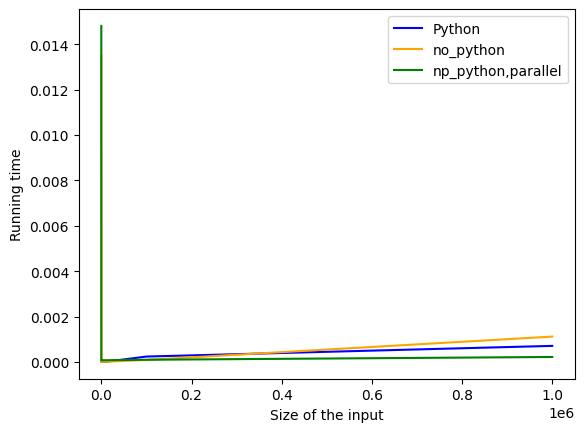

In [95]:
plt.plot(l_N,exec_times_mean[0],label='Python',color='blue')
plt.plot(l_N,exec_times_mean[1],label='no_python',color='orange')
plt.plot(l_N,exec_times_mean[2],label='np_python,parallel',color='green')
plt.legend()
plt.xlabel('Size of the input') 
plt.ylabel('Running time')  

Text(0, 0.5, 'Running time')

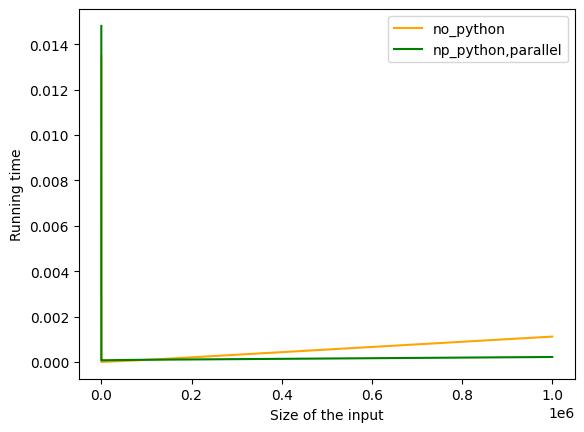

In [96]:
plt.plot(l_N,exec_times_mean[1],label='no_python',color='orange')
plt.plot(l_N,exec_times_mean[2],label='np_python,parallel',color='green')
plt.legend()
plt.xlabel('Size of the input') 
plt.ylabel('Running time')  

In [63]:
def py_euclidean_distance(x,y):
    distance = np.sqrt(np.sum((x-y)**2))
    return distance 

In [64]:
@jit(nopython=True)
def njit_euclidean_distance(x,y):
    distance = np.sqrt(np.sum((x-y)**2))
    return distance 

@jit(nopython=True, parallel=True)
def parallel_euclidean_distance(x,y):
    distance = np.sqrt(np.sum((x-y)**2))
    return distance 

In [65]:
l_N = [10, 100, 1000, 10000, 100000, 1000000]
my_methods = [
    py_euclidean_distance, njit_euclidean_distance, parallel_euclidean_distance
]

In [66]:
exec_times_N = np.zeros(shape=(3,10,len(l_N)))
for i_N in range(len(l_N)):
    # generating arrays
    N = l_N[i_N]
    x = np.random.randint(1000, size=N)/1000.
    y = np.random.randint(1000, size=N)/1000.

    for i in range(len(my_methods)):
        f = my_methods[i]
        for j in range(10):
            t = time()
            f(x,y)
            t = time()-t
            exec_times_N[i,j,i_N] = t

In [67]:
exec_times_mean = np.mean(exec_times_N,axis=1)
exec_times_mean

array([[1.37329102e-05, 2.88486481e-06, 3.40938568e-06, 9.39369202e-06,
        2.37131119e-04, 7.07268715e-04],
       [1.34883642e-02, 4.76837158e-07, 1.00135803e-06, 9.20295715e-06,
        8.83579254e-05, 1.11672878e-03],
       [1.48050308e-02, 7.02142715e-05, 7.22885132e-05, 7.54117966e-05,
        9.58204269e-05, 2.18343735e-04]])

Text(0, 0.5, 'Running time')

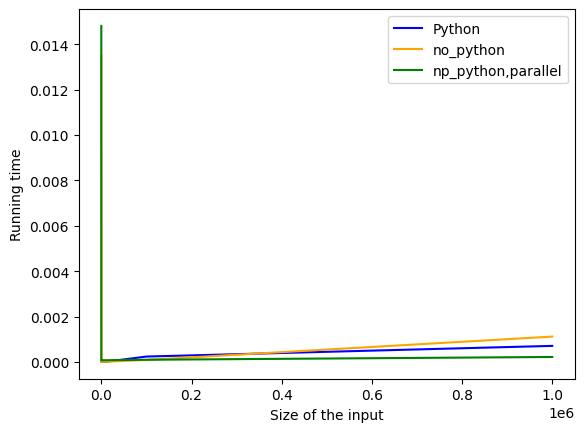

In [97]:
plt.plot(l_N,exec_times_mean[0],label='Python',color='blue')
plt.plot(l_N,exec_times_mean[1],label='no_python',color='orange')
plt.plot(l_N,exec_times_mean[2],label='np_python,parallel',color='green')
plt.legend()
plt.xlabel('Size of the input') 
plt.ylabel('Running time')  

Text(0, 0.5, 'Running time')

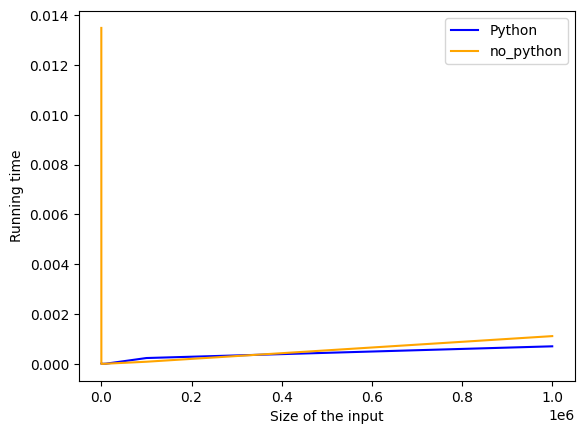

In [98]:
plt.plot(l_N,exec_times_mean[0],label='Python',color='blue')
plt.plot(l_N,exec_times_mean[1],label='no_python',color='orange')
plt.legend()
plt.xlabel('Size of the input') 
plt.ylabel('Running time')  

Text(0, 0.5, 'Running time')

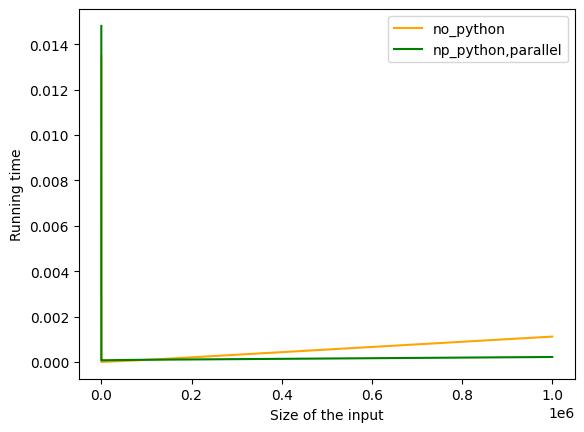

In [99]:
plt.plot(l_N,exec_times_mean[1],label='no_python',color='orange')
plt.plot(l_N,exec_times_mean[2],label='np_python,parallel',color='green')
plt.legend()
plt.xlabel('Size of the input') 
plt.ylabel('Running time')  

## Matrices

### Solving linear equations with `numpy`

$$
Ax = b
$$

$$
x = A^{-1}b
$$

Sometimes, when we try to implement an algorithm, an implementation that strictly follows the original mathematical definition is usually not optimal. In this case, getting the inverse makes use of an algorithm that has high complexity $O(n^3)$. It is generally not recommended to take matrix inverse unless you really need it. 

In [72]:
import numpy as np
from numba import jit


A = np.random.randn(1000,1000)
b = np.random.randn(1000,1)

In [73]:
%timeit np.linalg.inv(A)@b

19.4 ms ± 59 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


However, using a different algorithm can efficiently speed up the computation, producing the exact same results. This algorithm uses [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition) with partial pivoting to compute the solution fastly. You do not need to know about the mathematical details behind. But it is important to remember that `numpy` already offers many nearly optimal solutions. 

In [74]:
%timeit np.linalg.solve(A,b)

14.9 ms ± 199 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


using just-in-time compilation can make it faster.

In [75]:
jit(nopython=True)
def numba_solve(A,b):
    return np.linalg.solve(A,b)

In [76]:
%timeit numba_solve(A,b)

14.9 ms ± 58.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You can also parallelize it. However, the benefits of parallelization is dependent on a lot of factors, including how many cores you have, the dimension of your matrix, etc. You might not always see a speed up. And not all matrix operations can be parallelized. Sometimes if there is an iterative algorithm that needs multiple sequential steps to compute, it is unlikely that you will see benefits of parallelization. 

In [77]:
jit(nopython=True,parallel=True)
def numba_solve_parallel(A,b):
    return np.linalg.solve(A,b)

In [78]:
%timeit numba_solve_parallel(A,b)

15 ms ± 163 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Singular value decomposition

In [81]:
import numpy as np

In [82]:
#Creating a matrix M
M = np.array([[4,2,0],[1,5,6]])

This content is adapted from [Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition):

$$
M = U\Sigma V^T
$$

![Alt text](image-11.png)

The `np.linalg.svd function` calculates the SVD of the matrix M. The function returns three outputs: $U$, $\Sigma$, and $V^T$.

$U$ is a unitary matrix (orthogonal in the real case) representing the left singular vectors of M. It has shape (m, m) if M is an m x n matrix.
$\Sigma$ is a 1-dimensional array containing the singular values of M. The singular values are sorted in descending order.
$V^T$ is also a unitary matrix (orthogonal in the real case) representing the right singular vectors of M. It has shape (n, n) if M is an m x n matrix.
By assigning the outputs of np.linalg.svd(M) to  $U$, $\Sigma$, and $V^T$, you obtain the calculated singular vectors and singular values of M.

Why it is important? It has many nice properties that can help us optimize matrix computation. It is used widely in almost every field in science. 

In [83]:
#Performing SVD
U, Sigma, Vt = np.linalg.svd(M)

In [84]:
print("-------------------U-------------------")
print(U)
print("\n--------------Sigma----------------")
print(Sigma)
print("\n-------------V transpose---------------")
print(Vt)

-------------------U-------------------
[[ 0.28978415  0.95709203]
 [ 0.95709203 -0.28978415]]

--------------Sigma----------------
[8.13872588 3.97003036]

-------------V transpose---------------
[[ 0.26001965  0.65919758  0.70558368]
 [ 0.89132415  0.11719389 -0.43795758]
 [ 0.37139068 -0.74278135  0.55708601]]


In [86]:
#Checking if we can remake the original matrix using U, Sigma, Vt

newSigma = np.zeros((2, 3))
newSigma[:2, :2] = np.diag(Sigma[:2])

print(A,"\n")

M_remake = (U @ newSigma @ Vt)
print(M_remake)

[[4 2 0]
 [1 5 6]] 

[[ 4.00000000e+00  2.00000000e+00 -1.98846401e-16]
 [ 1.00000000e+00  5.00000000e+00  6.00000000e+00]]


In [87]:
# Verify orthonormal properties of U and V. (Peformed on U but the same applies for V).
#  1) Dot product between columns = 0
print(U@U.T)
print(U.T@U)


[[ 1.00000000e+00 -7.49665933e-17]
 [-7.49665933e-17  1.00000000e+00]]
[[ 1.00000000e+00 -7.49665933e-17]
 [-7.49665933e-17  1.00000000e+00]]


In [88]:

#  2) Columns are unit vectors (length = 1)
print(np.dot(U[:,0],U[:,0]))

print(np.dot(U[0,:],U[0,:]))


1.0
1.0


In [89]:

#  3) Multiplying by its transpose = identity matrix
np.allclose(U.T @ U, np.identity(len(U)))


True

We know that there are only $r$ singular values, where $r$ is the rank of the matrix. The full SVD is redundant. We can also perform truncated SVD to save some space.

In truncated SVD,   
 - $U_r$: The left singular vectors matrix with dimensions $m \times r$.  
 - $Σ_r$: A diagonal matrix containing only the top k singular values, with dimensions $r \times r$.  
 - $V^T_r$: The right singular vectors matrix with dimensions $r \times n$.  


In [90]:
#Performing SVD
U, Sigma, Vt = np.linalg.svd(M,full_matrices=False)

#### Low-rank matrix approximation

The content is adapted from this [background reading](https://en.wikipedia.org/wiki/Low-rank_approximation#:~:text=In%20mathematics%2C%20low%2Drank%20approximation,approximating%20matrix%20has%20reduced%20rank.)

First, let’s define the rank of the matrix: There are many ways one can define the rank of a matrix. Rank of
Matrix $M$, rank($M$), is the number of linearly independent columns in M. It is also equal to the number of
linearly independent rows in M. In addition, it is equal to the number of none-zero eigenvalues (or singular
values) of $M$.

Low-rank matrix approximation through Singular Value Decomposition (SVD) is a technique that involves approximating a given matrix by retaining only a reduced number of singular values and their corresponding singular vectors. This approach is a fundamental application of SVD and is used for dimensionality reduction, data compression, and feature extraction.

1. SVD Decomposition: Given a matrix $M$ of size $m \times n$, you perform SVD on it to factorize it into three matrices:
    - $U$: The left singular vectors matrix, which is $m \times m$.
    - $\Sigma$ (Sigma): A diagonal matrix containing the singular values in descending order, with dimensions $m \times n$.
    - $V^T$ (the transpose of $V$): The right singular vectors matrix, which is $n \times n$.


2. Rank Reduction: To perform low-rank matrix approximation, you reduce the rank of Σ by keeping only the top k singular values and corresponding columns from U and rows from Vt. This results in three reduced matrices:

    - $U_k$: The left singular vectors matrix with dimensions $m \times k$.
    - $Σ_k$: A diagonal matrix containing only the top k singular values, with dimensions $k \times k$.
    - $V^T_k$: The right singular vectors matrix with dimensions $k \times n$.


3. Approximation: The original matrix A can be approximated as the product of the three reduced matrices:

    - $M ≈ U_k  Σ_k  V^T_k$
    
    Choosing k: The choice of k depends on the desired level of approximation. A smaller k results in a lower-rank approximation, which may retain only the most significant features or patterns in the original matrix.

In [91]:
from matplotlib.image import imread 
import matplotlib.pyplot as plt 
import numpy as np 
import os 

(1602, 1200)


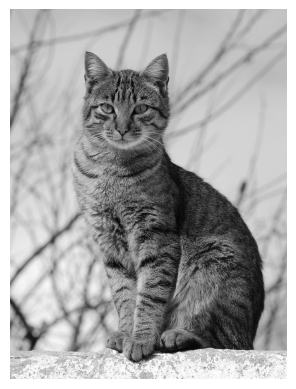

In [94]:


#The file MUST be in the same folder 
M = imread('cat.jpg') 

#Calculates the mean of the image `M` along the last axis (`-1`), which corresponds to averaging the color channels of the image. 
#The resulting `X` is a grayscale representation of the image.
X = np.mean(M, -1) 
print(X.shape)
img = plt.imshow(X) 
img.set_cmap('gray')
plt.axis('off') 
plt.show() 

Notice that we can reconstruct the original image pretty faithfully with a small number of ranks. The resulting $U_k$, $\Sigma_k$ and $V^T_k$ usually contains less elements than the original $m \times n$ matrix. You can verify this on your own!

(1602, 1200)
(1200,)
(1200, 1200)
[[2.22378068e+05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.09775994e+04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.02682842e+04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.70260083e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.54736527e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 3.41082188e+00]]


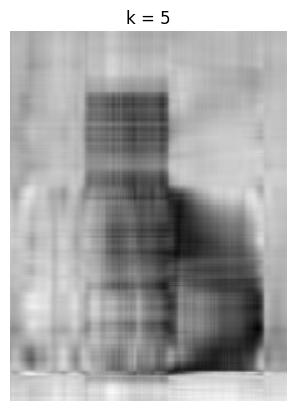

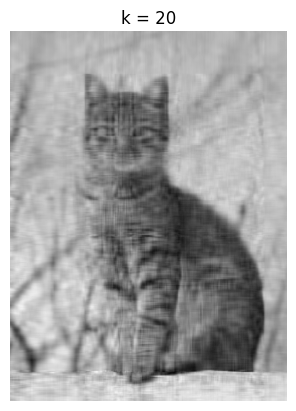

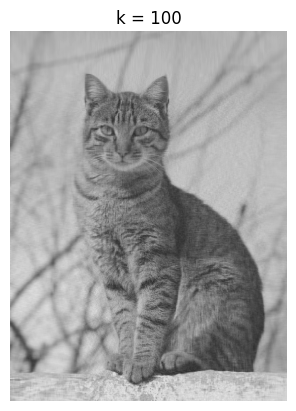

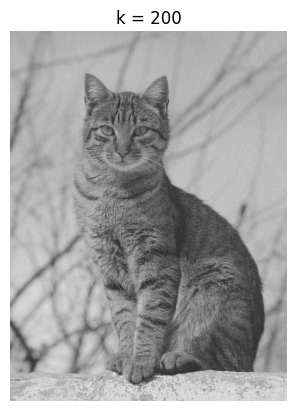

In [93]:
#Computing regular SVD 
U, S, VT = np.linalg.svd(X, full_matrices = False) 
print(U.shape)
print(S.shape)
print(VT.shape)
#Extract Diagonal Singular Values from the Sigma Matrix 
S = np.diag(S) 
print(S)
i = 0 
for k in (5, 20, 100, 200): 
    #Constructing the approximate images in the setted ranks 
    X_Ap = U[:,:k] @ S[0:k,:k] @ VT[:k,:] 
    plt.figure(i+1) 
    i += 1
    img = plt.imshow(X_Ap) 
    img.set_cmap('gray') 
    plt.axis('off') 
    plt.title('k = ' + str(k)) 
    plt.show() 

This code snippet performs the reconstruction of the approximate images using different ranks k. Inside the loop, it constructs the approximate image X_Ap by selecting the first k columns from U, the first k rows and columns from S, and the first k rows from VT.

Then, it creates a new figure using plt.figure and increments the figure number i. The imshow function is used to display the approximate image X_Ap, and img.set_cmap('gray') sets the colormap to grayscale. The plt.axis('off') command turns off the axis labels and ticks for the plot. Finally, plt.title sets the title of the plot to indicate the value of k, and plt.show() displays the plot.